In [46]:
import json
import os
import re
import sqlite3

import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [2]:
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [4]:
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

## Load data

Data sources:

**CGFP** (big Excel spreadsheet) has the list of food products that we want to study
* `Product GTIN or UPC`: globally unique identifier, but unfortunately it's sparsely populated
* `Vendor`: the parent company, such as `"GENERAL MILLS REFRIGERATE"`
* `Brand Name`: a consumer-facing name for a whole series of products, such as `"YOPLAIT"`
* `Product Type`: a specific food product, maybe abbreviated, like `"YOGURT STRWBRY BANANA BASH TRIX"`
* `Level of Processing`: NOVA group, determined manually by CGFP
* does not have a list of ingredients or nutrition facts

**USDA** (branded_food.csv) can link to lists of ingredients
* `gtin_upc`: the same globally unique identifier, but matching has low recall
* `brand_owner`: the parent company, such as `"GENERAL MILLS SALES INC."`
* `brand_name`: a consumer-facing name for a whole series of products, such as `"Yoplait"`
* `subbrand_name`: not always present, but in this case `"Trix"`
* `short_description`: a specific food product, maybe abbreviated, like `"Yplt Trix StrwbrryBan LF Yogrt"`
* `ingredients`: what we want!

A 2% sample of CGFP↔USDA ground truth matches can be made through GTIN/UPC.

Then we want to see how much closer brand names and product descriptions are for the true matches in an embedding space than random (and usually false) pairs are. Can closeness in an embedding space, possibly with ChatGPT clean-up provide higher-recall matches?

### Load CGFP

In [5]:
cgfp = pd.read_csv(
    "~/Box/dsi-core/11th-hour/good-food-purchasing/CONFIDENTIAL_GFPP Product Attribute List_8.26.25.csv",
    dtype=str,
)[
    [
        "Product GTIN or UPC",
        "Vendor",
        "Brand Name",
        "Product Type",
        "Level of Processing",
    ]
]
cgfp_with_upc = cgfp[
    cgfp["Product GTIN or UPC"].notna() & ~cgfp["Product GTIN or UPC"].isin(["#REF!"])
].copy()
cgfp_with_upc["Product GTIN or UPC"] = cgfp_with_upc["Product GTIN or UPC"].apply(
    lambda x: f"{int(float(x.replace(' ', ''))):014d}"
)

### Load USDA

In [6]:
usda = pd.read_csv(
    "~/Box/dsi-core/11th-hour/good-food-purchasing/branded_food.csv",
    dtype=str,
)[
    [
        "gtin_upc",
        "brand_owner",
        "brand_name",
        "subbrand_name",
        "short_description",
        "ingredients",
    ]
]
usda["gtin_upc"] = (
    usda["gtin_upc"]
    .str.replace("-", "")
    .str.replace(" ", "")
    .str.replace("`", "")
    .str.replace("X", "")
    .str.replace(">", "")
    .apply(
        lambda x: {
            "NIELSENUK0002": np.nan,
            "OldCountryStore": np.nan,
            "JARLSBERG": np.nan,
            "BOOST": np.nan,
            "HAPPYKIDORGANICS": np.nan,
        }.get(x, x)
    )
    .astype(np.float64)
)
usda_with_upc = usda[usda["gtin_upc"].notna()].copy()
usda_with_upc["gtin_upc"] = usda_with_upc["gtin_upc"].apply(lambda x: f"{int(x):014d}")

## Matching CGFP and USDA

In [7]:
cgfp_usda = cgfp_with_upc.reset_index().merge(
    usda_with_upc.reset_index(), left_on="Product GTIN or UPC", right_on="gtin_upc"
)

In [8]:
len(cgfp_usda) / len(cgfp)

0.02688784024224474

In [9]:
cgfp_usda[
    [
        "Vendor",
        "Brand Name",
        "Product Type",
        "brand_owner",
        "brand_name",
        "subbrand_name",
        "short_description",
    ]
]

,Vendor,Brand Name,Product Type,brand_owner,brand_name,subbrand_name,short_description
0,Sysco Hawaii,NaN,"BREAD PITA PRE-OILED GYROS W/O POCKET 7""",Kontos Foods Inc.,NaN,NaN,NaN
1,Sysco Hawaii,NaN,"BREAD PITA PRE-OILED GYROS W/O POCKET 7""",Kontos Foods Inc.,NaN,NaN,NaN
2,Sysco Hawaii,NaN,"BREAD PITA PRE-OILED GYROS W/O POCKET 7""",Kontos Foods Inc.,KONTOS,NaN,NaN
3,Sysco Hawaii,NaN,"BREAD PITA PRE-OILED GYROS W/O POCKET 7""",Kontos Foods Inc.,KONTOS,NaN,NaN
4,Sysco Hawaii,NaN,"BREAD PITA PRE-OILED GYROS W/O POCKET 7""",Kontos Foods Inc.,KONTOS,NaN,NaN
...,...,...,...,...,...,...,...
2428,Performance Food Service,YOPLAIT,YOGURT RSPBRY RAINBOW TRIX TFF,GENERAL MILLS SALES INC.,Yoplait,NaN,Yoplt Trix Raspberry LF Yogurt
2429,Performance Food Service,YOPLAIT,YOGURT RSPBRY RAINBOW TRIX TFF,GENERAL MILLS SALES INC.,Yoplait,NaN,Yoplt Trix Raspberry LF Yogurt
2430,Performance Food Service,YOPLAIT,YOGURT STRWBRY BANANA BASH TRIX,GENERAL MILLS SALES INC.,Yoplait,Trix,Yplt Trix StrwbrryBan LF Yogrt
2431,Performance Food Service,YOPLAIT,YOGURT STRWBRY BANANA BASH TRIX,GENERAL MILLS SALES INC.,Yoplait,Trix,Yplt Trix StrwbrryBan LF Yogrt


In [ ]:
is_good_match = []
for i, (_, row) in tqdm(enumerate(cgfp_usda.iterrows()), total=len(cgfp_usda)):
    cgfp_vendor = "" if not isinstance(row["Vendor"], str) else row["Vendor"]
    cgfp_brand = "" if not isinstance(row["Brand Name"], str) else row["Brand Name"]
    cgfp_product = (
        "" if not isinstance(row["Product Type"], str) else row["Product Type"]
    )
    usda_vendor = "" if not isinstance(row["brand_owner"], str) else row["brand_owner"]
    usda_brand = ", ".join(
        [
            x
            for x in [
                "" if not isinstance(row["brand_name"], str) else row["brand_name"],
                (
                    ""
                    if not isinstance(row["subbrand_name"], str)
                    else row["subbrand_name"]
                ),
            ]
            if x != ""
        ]
    )
    usda_product = (
        ""
        if not isinstance(row["short_description"], str)
        else row["short_description"]
    )

    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers={
                "Content-Type": "application/json",
                "Authorization": f"Bearer {OPENAI_API_KEY}",
            },
            json={
                "model": "gpt-4.1",
                "messages": [
                    {
                        "role": "system",
                        "content": """
You are comparing food products from two databases. Return `{"is_good_match": true}`
if the food product described by the first group of data fields is like the same
food product as described by the second group.
""".strip(),
                    },
                    {
                        "role": "user",
                        "content": f"""
vendor: {cgfp_vendor}
brand: {cgfp_brand}
product: {cgfp_product}

vendor: {usda_vendor}
brand: {usda_brand}
product: {usda_product}
""".strip(),
                    },
                ],
                "response_format": {
                    "type": "json_schema",
                    "json_schema": {
                        "name": "is_good_match",
                        "schema": {
                            "type": "object",
                            "properties": {
                                "is_good_match": {"type": "boolean"},
                            },
                            "required": ["is_good_match"],
                            "additionalProperties": False,
                        },
                    },
                },
                "n": 5,
            },
        )
        results = [
            json.loads(result["message"]["content"])["is_good_match"]
            for result in response.json()["choices"]
        ]
        is_good_match.append(sum(results))
    except Exception:
        is_good_match.append(None)

In [ ]:
cgfp_usda["is_good_match"] = is_good_match

In [ ]:
cgfp_usda.to_csv(
    "~/Box/dsi-core/11th-hour/good-food-purchasing/cgfp_usda_good_match.csv",
    index=False,
)

In [13]:
cgfp_usda = pd.read_csv(
    "~/Box/dsi-core/11th-hour/good-food-purchasing/cgfp_usda_good_match.csv"
)

## How well do they match in sentence transformers?

In [15]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [16]:
cgfp_usda_best = (
    cgfp_usda.query("is_good_match.notna() and is_good_match >= 5")
    .drop_duplicates()
    .copy()
)

Compute embeddings for all of the good matches (matched by GTIN/UPC).

In [27]:
cgfp_brand_product = []
usda_brand_product = []
cgfp_vendor_brand_product = []
usda_vendor_brand_product = []

for _, row in cgfp_usda_best.iterrows():
    cgfp_vendor = "" if not isinstance(row["Vendor"], str) else row["Vendor"]
    cgfp_brand = "" if not isinstance(row["Brand Name"], str) else row["Brand Name"]
    cgfp_product = (
        "" if not isinstance(row["Product Type"], str) else row["Product Type"]
    )
    usda_vendor = "" if not isinstance(row["brand_owner"], str) else row["brand_owner"]
    usda_brand = ", ".join(
        [
            x
            for x in [
                "" if not isinstance(row["brand_name"], str) else row["brand_name"],
                (
                    ""
                    if not isinstance(row["subbrand_name"], str)
                    else row["subbrand_name"]
                ),
            ]
            if x != ""
        ]
    )
    usda_product = (
        ""
        if not isinstance(row["short_description"], str)
        else row["short_description"]
    )

    cgfp_brand_product.append(f"{cgfp_brand} {cgfp_product}")
    usda_brand_product.append(f"{usda_brand} {usda_product}")
    cgfp_vendor_brand_product.append(f"{cgfp_vendor} {cgfp_brand} {cgfp_product}")
    usda_vendor_brand_product.append(f"{usda_vendor} {usda_brand} {usda_product}")

cgfp_brand_product = model.encode(cgfp_brand_product)
usda_brand_product = model.encode(usda_brand_product)
cgfp_vendor_brand_product = model.encode(cgfp_vendor_brand_product)
usda_vendor_brand_product = model.encode(usda_vendor_brand_product)

Print out all of the good matches with the vendor-brand-product and brand-product cosine similarities (`dot`).

(It's just a dot product because the sentence transformer model returns normalized vectors.)

In [28]:
print(f"        | {'CGFP':50s} | {'USDA':50s} |  dot")

for i, (_, row) in enumerate(cgfp_usda_best.iterrows()):
    cgfp_vendor = "" if not isinstance(row["Vendor"], str) else row["Vendor"]
    cgfp_brand = "" if not isinstance(row["Brand Name"], str) else row["Brand Name"]
    cgfp_product = (
        "" if not isinstance(row["Product Type"], str) else row["Product Type"]
    )
    usda_vendor = "" if not isinstance(row["brand_owner"], str) else row["brand_owner"]
    usda_brand = ", ".join(
        [
            x
            for x in [
                "" if not isinstance(row["brand_name"], str) else row["brand_name"],
                (
                    ""
                    if not isinstance(row["subbrand_name"], str)
                    else row["subbrand_name"]
                ),
            ]
            if x != ""
        ]
    )
    usda_product = (
        ""
        if not isinstance(row["short_description"], str)
        else row["short_description"]
    )
    print(
        f"""--------+-{'-' * 50}-+-{'-' * 50}-+------
vendor  | {cgfp_vendor[:50]:50s} | {usda_vendor[:50]:50s} | {np.dot(cgfp_vendor_brand_product[i], usda_vendor_brand_product[i]):5.2f}
brand   | {cgfp_brand[:50]:50s} | {usda_brand[:50]:50s} | {np.dot(cgfp_brand_product[i], usda_brand_product[i]):5.2f}
product | {cgfp_product[:50]:50s} | {usda_product[:50]:50s} |"""
    )

        | CGFP                                               | USDA                                               |  dot
--------+----------------------------------------------------+----------------------------------------------------+------
vendor  | Sysco Hawaii                                       | Kontos Foods Inc.                                  |  0.19
brand   |                                                    |                                                    | -0.00
product | BREAD PITA PRE-OILED GYROS W/O POCKET 7"           |                                                    |
--------+----------------------------------------------------+----------------------------------------------------+------
vendor  | Sysco Hawaii                                       | Kontos Foods Inc.                                  |  0.19
brand   |                                                    |                                                    | -0.00
product | BREAD PITA PRE-OILED 

Compute a sample of _wrong_ pairs from a random permutation of the input datasets.

In [29]:
wrong_cgfp_brand_product = []
wrong_usda_brand_product = []
wrong_cgfp_vendor_brand_product = []
wrong_usda_vendor_brand_product = []

for (_, cgfp_row), (_, usda_row) in zip(
    cgfp.take(np.random.permutation(len(cgfp))[:100000]).iterrows(),
    usda.take(np.random.permutation(len(usda))[:100000]).iterrows(),
):
    cgfp_vendor = "" if not isinstance(cgfp_row["Vendor"], str) else cgfp_row["Vendor"]
    cgfp_brand = (
        "" if not isinstance(cgfp_row["Brand Name"], str) else cgfp_row["Brand Name"]
    )
    cgfp_product = (
        ""
        if not isinstance(cgfp_row["Product Type"], str)
        else cgfp_row["Product Type"]
    )
    usda_vendor = (
        "" if not isinstance(usda_row["brand_owner"], str) else usda_row["brand_owner"]
    )
    usda_brand = ", ".join(
        [
            x
            for x in [
                (
                    ""
                    if not isinstance(usda_row["brand_name"], str)
                    else usda_row["brand_name"]
                ),
                (
                    ""
                    if not isinstance(usda_row["subbrand_name"], str)
                    else usda_row["subbrand_name"]
                ),
            ]
            if x != ""
        ]
    )
    usda_product = (
        ""
        if not isinstance(usda_row["short_description"], str)
        else usda_row["short_description"]
    )

    wrong_cgfp_brand_product.append(f"{cgfp_brand} {cgfp_product}")
    wrong_usda_brand_product.append(f"{usda_brand} {usda_product}")
    wrong_cgfp_vendor_brand_product.append(f"{cgfp_vendor} {cgfp_brand} {cgfp_product}")
    wrong_usda_vendor_brand_product.append(f"{usda_vendor} {usda_brand} {usda_product}")

wrong_cgfp_brand_product = model.encode(wrong_cgfp_brand_product)
wrong_usda_brand_product = model.encode(wrong_usda_brand_product)
wrong_cgfp_vendor_brand_product = model.encode(wrong_cgfp_vendor_brand_product)
wrong_usda_vendor_brand_product = model.encode(wrong_usda_vendor_brand_product)

How do `vendor_brand_product` and `brand_product` dot products compare? Is there an advantage to including the vendor information?

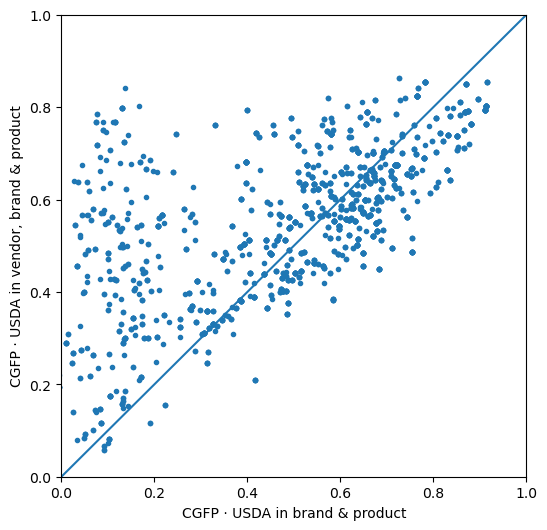

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    [np.dot(x, y) for x, y in zip(cgfp_brand_product, usda_brand_product)],
    [
        np.dot(x, y)
        for x, y in zip(cgfp_vendor_brand_product, usda_vendor_brand_product)
    ],
    marker=".",
)
ax.plot([0, 1], [0, 1])

ax.set_xlabel("CGFP \u00b7 USDA in brand & product")
ax.set_ylabel("CGFP \u00b7 USDA in vendor, brand & product")

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

None

How about for the wrong/random pairs?

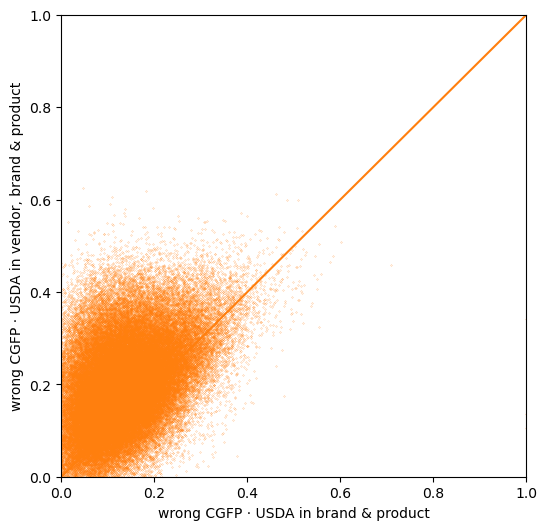

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    [np.dot(x, y) for x, y in zip(wrong_cgfp_brand_product, wrong_usda_brand_product)],
    [
        np.dot(x, y)
        for x, y in zip(
            wrong_cgfp_vendor_brand_product, wrong_usda_vendor_brand_product
        )
    ],
    marker=".",
    color=default_colors[1],
    s=0.1,
)
ax.plot([0, 1], [0, 1], color=default_colors[1])

ax.set_xlabel("wrong CGFP \u00b7 USDA in brand & product")
ax.set_ylabel("wrong CGFP \u00b7 USDA in vendor, brand & product")

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

None

Now show histograms for the wrong/random pairs, for `vendor_band_product` and `brand_product`, to see how the tails of their distributions compare.

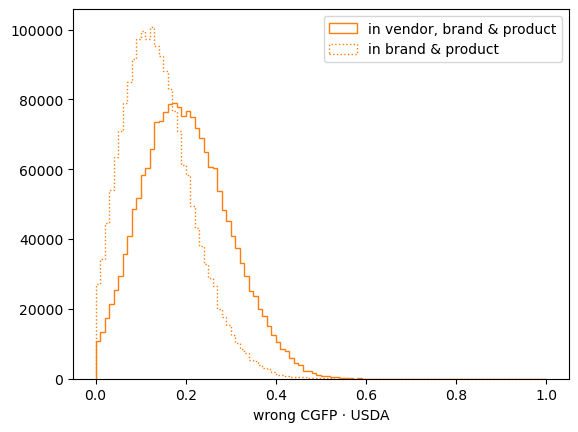

In [32]:
fig, ax = plt.subplots()

ax.hist(
    [
        np.dot(x, y)
        for x, y in zip(
            wrong_cgfp_vendor_brand_product, wrong_usda_vendor_brand_product
        )
    ],
    bins=100,
    range=(0, 1),
    weights=np.full(
        len(wrong_cgfp_vendor_brand_product),
        len(usda) / len(wrong_cgfp_vendor_brand_product),
    ),
    color=default_colors[1],
    histtype="step",
    label="in vendor, brand & product",
)
ax.hist(
    [np.dot(x, y) for x, y in zip(wrong_cgfp_brand_product, wrong_usda_brand_product)],
    bins=100,
    range=(0, 1),
    weights=np.full(
        len(wrong_cgfp_brand_product), len(usda) / len(wrong_cgfp_brand_product)
    ),
    color=default_colors[1],
    histtype="step",
    ls=":",
    label="in brand & product",
)
ax.legend()

ax.set_xlabel("wrong CGFP \u00b7 USDA")

None

Now overlay good matches and wrong/random pairs on the same plot, in the same scale: the orange wrong/random is scaled to have the same number of elements as the USDA dataset, while the blue good matches has as many entries as good matches. If we had a database of USDA embeddings and asked, which ones match a given CGFP item, what's the probability of getting a correct result? (Integrate from some chosen threshold, like 0.6, upward to get probability.)

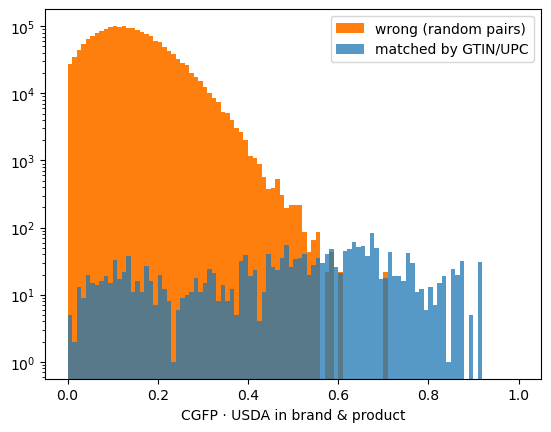

In [33]:
fig, ax = plt.subplots()

ax.hist(
    [np.dot(x, y) for x, y in zip(wrong_cgfp_brand_product, wrong_usda_brand_product)],
    bins=100,
    range=(0, 1),
    weights=np.full(
        len(wrong_cgfp_brand_product),
        len(usda) / len(wrong_cgfp_brand_product),
    ),
    color=default_colors[1],
    label="wrong (random pairs)",
)
ax.hist(
    [np.dot(x, y) for x, y in zip(cgfp_brand_product, usda_brand_product)],
    bins=100,
    range=(0, 1),
    color=default_colors[0],
    alpha=0.75,
    label="matched by GTIN/UPC",
)

ax.legend()

ax.set_xlabel("CGFP \u00b7 USDA in brand & product")
ax.set_yscale("log")

None

Same for the `vendor_brand_product`.

Even though wrong/random pairs have a lower-mean distribution in `band_product`, the tail is longer. For better signal-to-background, use `vendor_brand_product`.

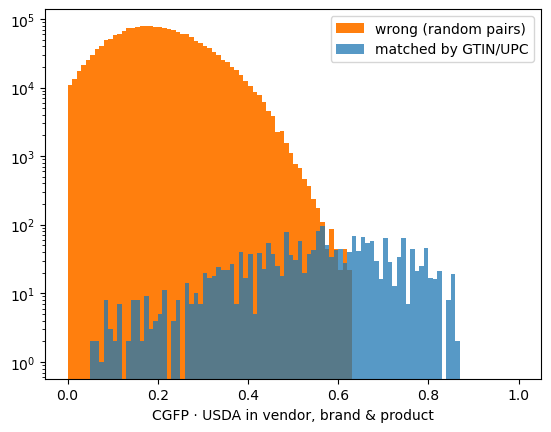

In [34]:
fig, ax = plt.subplots()

ax.hist(
    [
        np.dot(x, y)
        for x, y in zip(
            wrong_cgfp_vendor_brand_product, wrong_usda_vendor_brand_product
        )
    ],
    bins=100,
    range=(0, 1),
    weights=np.full(
        len(wrong_cgfp_vendor_brand_product),
        len(usda) / len(wrong_cgfp_vendor_brand_product),
    ),
    color=default_colors[1],
    label="wrong (random pairs)",
)
ax.hist(
    [
        np.dot(x, y)
        for x, y in zip(cgfp_vendor_brand_product, usda_vendor_brand_product)
    ],
    bins=100,
    range=(0, 1),
    color=default_colors[0],
    alpha=0.75,
    label="matched by GTIN/UPC",
)

ax.legend()

ax.set_xlabel("CGFP \u00b7 USDA in vendor, brand & product")
ax.set_yscale("log")

None

## Save a database of USDA embeddings

I'll use this tomorrow to match CGFP food products.

In [52]:
usda_index_database = []
usda_gtinupc_database = []
usda_ingredients_database = []
usda_vendor_database = []
usda_brand_database = []
usda_product_database = []
usda_vendor_brand_product_database = []

for index, (_, row) in tqdm(enumerate(usda.iterrows()), total=len(usda)):
    usda_vendor = "" if not isinstance(row["brand_owner"], str) else row["brand_owner"]
    usda_brand = ", ".join(
        [
            x
            for x in [
                ("" if not isinstance(row["brand_name"], str) else row["brand_name"]),
                (
                    ""
                    if not isinstance(row["subbrand_name"], str)
                    else row["subbrand_name"]
                ),
            ]
            if x != ""
        ]
    )
    usda_product = (
        ""
        if not isinstance(row["short_description"], str)
        else row["short_description"]
    )

    usda_index_database.append(index)
    usda_gtinupc_database.append(
        "" if np.isnan(row["gtin_upc"]) else f"{int(row['gtin_upc']):014d}"
    )
    usda_ingredients_database.append(
        "" if not isinstance(row["ingredients"], str) else row["ingredients"]
    )
    usda_vendor_database.append(usda_vendor)
    usda_brand_database.append(usda_brand)
    usda_product_database.append(usda_product)
    usda_vendor_brand_product_database.append(
        f"{usda_vendor} {usda_brand} {usda_product}"
    )

usda_vendor_brand_product_database = model.encode(usda_vendor_brand_product_database)

100%|█████████████████████████████████████████████| 1977398/1977398 [01:04<00:00, 30503.51it/s]


In [53]:
np.save(
    os.path.expanduser(
        "~/Box/dsi-core/11th-hour/good-food-purchasing/branded_food-all-MiniLM-L6-v2.npy"
    ),
    usda_vendor_brand_product_database,
)

In [57]:
conn = sqlite3.connect(
    os.path.expanduser(
        "~/Box/dsi-core/11th-hour/good-food-purchasing/branded_food-all-MiniLM-L6-v2.sqlite"
    )
)
c = conn.cursor()

c.execute("""
CREATE TABLE IF NOT EXISTS branded_food (
    npy_index INTEGER PRIMARY KEY,
    gtin_upc TEXT,
    vendor TEXT,
    brand TEXT,
    product TEXT,
    ingredients TEXT
);
""")

rows = list(
    zip(
        usda_index_database,
        usda_gtinupc_database,
        usda_vendor_database,
        usda_brand_database,
        usda_product_database,
        usda_ingredients_database,
    )
)

c.executemany(
    "INSERT INTO branded_food (npy_index, gtin_upc, vendor, brand, product, ingredients) VALUES (?, ?, ?, ?, ?, ?);",
    rows,
)

conn.commit()
conn.close()